# Homework 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('car_fuel_efficiency.csv')

columns = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]

df = df[columns]


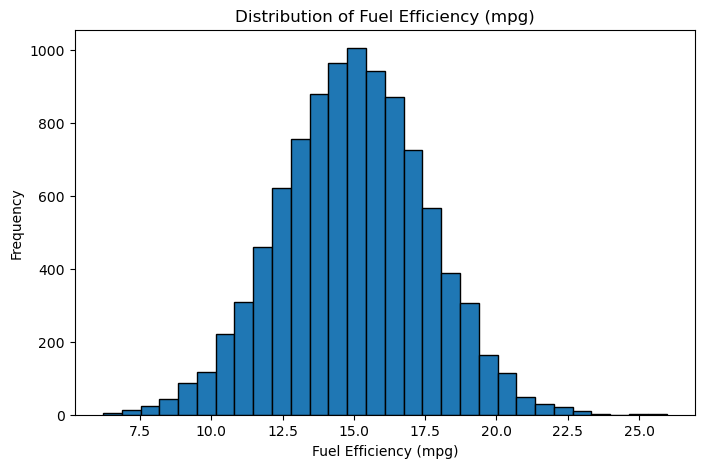

Skewness of fuel_efficiency_mpg: -0.01


In [3]:

plt.figure(figsize=(8, 5))
plt.hist(df['fuel_efficiency_mpg'], bins=30, edgecolor='k')
plt.xlabel('Fuel Efficiency (mpg)')
plt.ylabel('Frequency')
plt.title('Distribution of Fuel Efficiency (mpg)')
plt.show()

skewness = df['fuel_efficiency_mpg'].skew()
print(f"Skewness of fuel_efficiency_mpg: {skewness:.2f}")


## Question 1

In [4]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64


## Question 2

In [5]:
median_horsepower = df['horsepower'].median()
print(f"Median (50% percentile) of 'horsepower': {median_horsepower}")


Median (50% percentile) of 'horsepower': 149.0


In [6]:
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx].reset_index(drop=True)

n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - n_train - n_val

df_train = df_shuffled.iloc[:n_train].reset_index(drop=True)
df_val = df_shuffled.iloc[n_train:n_train+n_val].reset_index(drop=True)
df_test = df_shuffled.iloc[n_train+n_val:].reset_index(drop=True)

print(f"Train set: {len(df_train)} rows")
print(f"Validation set: {len(df_val)} rows")
print(f"Test set: {len(df_test)} rows")


Train set: 5822 rows
Validation set: 1940 rows
Test set: 1942 rows


## Question 3

In [7]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Features to use (excluding the target)
features = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year'
]
target = 'fuel_efficiency_mpg'

# Prepare training and validation sets
X_train = df_train[features].copy()
y_train = df_train[target].values

X_val = df_val[features].copy()
y_val = df_val[target].values

# Option 1: Fill missing 'horsepower' with 0
X_train_0 = X_train.copy()
X_val_0 = X_val.copy()
X_train_0['horsepower'] = X_train_0['horsepower'].fillna(0)
X_val_0['horsepower'] = X_val_0['horsepower'].fillna(0)

model_0 = LinearRegression()
model_0.fit(X_train_0, y_train)
y_pred_0 = model_0.predict(X_val_0)
rmse_0 = mean_squared_error(y_val, y_pred_0)
rmse_0 = round(np.sqrt(rmse_0), 2)
print(f"RMSE with 0 imputation: {rmse_0}")

# Option 2: Fill missing 'horsepower' with mean (from training set only)
mean_hp = X_train['horsepower'].mean()
X_train_mean = X_train.copy()
X_val_mean = X_val.copy()
X_train_mean['horsepower'] = X_train_mean['horsepower'].fillna(mean_hp)
X_val_mean['horsepower'] = X_val_mean['horsepower'].fillna(mean_hp)

model_mean = LinearRegression()
model_mean.fit(X_train_mean, y_train)
y_pred_mean = model_mean.predict(X_val_mean)
rmse_mean = mean_squared_error(y_val, y_pred_mean)
rmse_mean = round(np.sqrt(rmse_mean), 2)
print(f"RMSE with mean imputation: {rmse_mean}")


RMSE with 0 imputation: 0.52
RMSE with mean imputation: 0.46


## Question 4

In [8]:
from sklearn.linear_model import Ridge

r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = []

for r in r_values:
    model = Ridge(alpha=r)
    model.fit(X_train_0, y_train)
    y_pred = model.predict(X_val_0)
    mse = mean_squared_error(y_val, y_pred)
    rmse = round(np.sqrt(mse), 2)
    rmse_scores.append(rmse)
    print(f"r={r}: RMSE={rmse}")

best_rmse = min(rmse_scores)
best_r_indices = [i for i, score in enumerate(rmse_scores) if score == best_rmse]
best_r = r_values[min(best_r_indices)]
print(f"\nBest r: {best_r} with RMSE: {best_rmse}")


r=0: RMSE=0.52
r=0.01: RMSE=0.52
r=0.1: RMSE=0.52
r=1: RMSE=0.52
r=5: RMSE=0.52
r=10: RMSE=0.52
r=100: RMSE=0.52

Best r: 0 with RMSE: 0.52


## Question 5

In [9]:
from sklearn.model_selection import train_test_split

rmse_scores = []
seeds = list(range(10))

for seed in seeds:
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    n = len(df_shuffled)
    n_train = int(n * 0.6)
    n_val = int(n * 0.2)
    n_test = n - n_train - n_val

    df_train = df_shuffled.iloc[:n_train]
    df_val = df_shuffled.iloc[n_train:n_train+n_val]
    df_test = df_shuffled.iloc[n_train+n_val:]

    X_train = df_train.drop('fuel_efficiency_mpg', axis=1)
    y_train = df_train['fuel_efficiency_mpg']
    X_val = df_val.drop('fuel_efficiency_mpg', axis=1)
    y_val = df_val['fuel_efficiency_mpg']

    X_train_0 = X_train.fillna(0)
    X_val_0 = X_val.fillna(0)

    model = LinearRegression()
    model.fit(X_train_0, y_train)
    y_pred = model.predict(X_val_0)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

std = np.std(rmse_scores)
std_rounded = round(std, 3)
print(f"Standard deviation of RMSEs: {std_rounded}")


Standard deviation of RMSEs: 0.007


## Question 6

In [10]:
df_shuffled = df.sample(frac=1, random_state=9).reset_index(drop=True)

n = len(df_shuffled)
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val

df_train = df_shuffled.iloc[:n_train]
df_val = df_shuffled.iloc[n_train:n_train+n_val]
df_test = df_shuffled.iloc[n_train+n_val:]

df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

X_full_train = df_full_train.drop('fuel_efficiency_mpg', axis=1)
y_full_train = df_full_train['fuel_efficiency_mpg']
X_test = df_test.drop('fuel_efficiency_mpg', axis=1)
y_test = df_test['fuel_efficiency_mpg']

X_full_train_0 = X_full_train.fillna(0)
X_test_0 = X_test.fillna(0)

model = Ridge(alpha=0.001)
model.fit(X_full_train_0, y_full_train)
y_pred = model.predict(X_test_0)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse_rounded = round(rmse, 3)
print(f"RMSE on test set: {rmse_rounded}")


RMSE on test set: 0.515
